### Transfer learning ResNet50

In [1]:
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/dataset/skin_images/train'
validation_dir = '/content/drive/MyDrive/dataset/skin_images/test'

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2637 files belonging to 2 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 660 files belonging to 2 classes.


In [7]:
class_names = train_dataset.class_names

In [8]:
class_names

['benign', 'malignant']

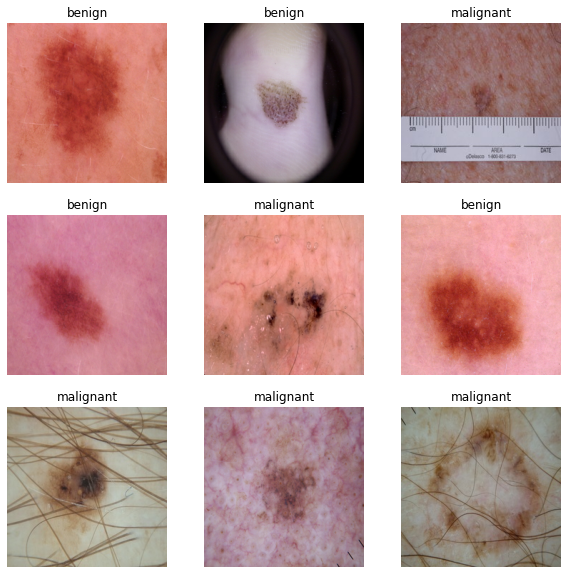

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create test set

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 17
Number of test batches: 4


### Configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

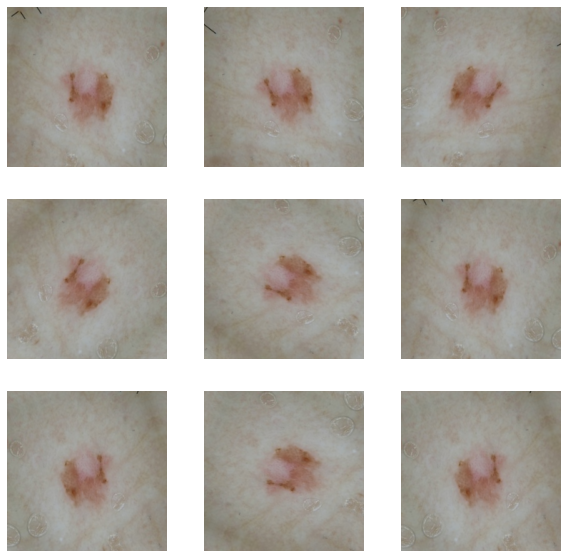

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In [15]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

### Create the base model from the pre-trained convnets

In [16]:
# Create the base model from the pre-trained model MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


### Feature extraction

In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Add a classification head

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [25]:
len(model.trainable_variables)

2

### Train the model

In [26]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

17/17 [==============================] - 105s 2s/step - loss: 0.8042 - accuracy: 0.5395


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.54


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
83/83 [==============================] - 200s 2s/step - loss: 0.7549 - accuracy: 0.5658 - val_loss: 0.6137 - val_accuracy: 0.6673
Epoch 2/10
83/83 [==============================] - 16s 191ms/step - loss: 0.6217 - accuracy: 0.6560 - val_loss: 0.5228 - val_accuracy: 0.7218
Epoch 3/10
83/83 [==============================] - 17s 193ms/step - loss: 0.5393 - accuracy: 0.7004 - val_loss: 0.4832 - val_accuracy: 0.7613
Epoch 4/10
83/83 [==============================] - 16s 189ms/step - loss: 0.4936 - accuracy: 0.7380 - val_loss: 0.4635 - val_accuracy: 0.7801
Epoch 5/10
83/83 [==============================] - 16s 190ms/step - loss: 0.4617 - accuracy: 0.7562 - val_loss: 0.4227 - val_accuracy: 0.7857
Epoch 6/10
83/83 [==============================] - 17s 193ms/step - loss: 0.4355 - accuracy: 0.7725 - val_loss: 0.4086 - val_accuracy: 0.7989
Epoch 7/10
83/83 [==============================] - 16s 192ms/step - loss: 0.4253 - accuracy: 0.7857 - val_loss: 0.4038 - val_accuracy: 0.7970
E

### Learning curves

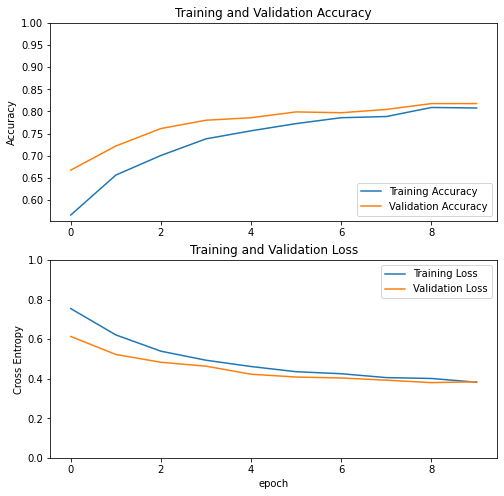

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

### Un-freeze the top layers of the model

In [30]:
base_model.trainable = True


In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [32]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the model

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [35]:
len(model.trainable_variables)

92

### Continue training the model

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
83/83 [==============================] - 35s 280ms/step - loss: 0.3396 - accuracy: 0.8430 - val_loss: 0.3527 - val_accuracy: 0.8553
Epoch 11/20
83/83 [==============================] - 24s 273ms/step - loss: 0.2722 - accuracy: 0.8802 - val_loss: 0.3017 - val_accuracy: 0.8590
Epoch 12/20
83/83 [==============================] - 23s 268ms/step - loss: 0.2408 - accuracy: 0.8934 - val_loss: 0.2852 - val_accuracy: 0.8628
Epoch 13/20
83/83 [==============================] - 24s 277ms/step - loss: 0.2240 - accuracy: 0.8965 - val_loss: 0.2869 - val_accuracy: 0.8665
Epoch 14/20
83/83 [==============================] - 24s 279ms/step - loss: 0.1921 - accuracy: 0.9048 - val_loss: 0.3099 - val_accuracy: 0.8891
Epoch 15/20
83/83 [==============================] - 23s 274ms/step - loss: 0.1798 - accuracy: 0.9177 - val_loss: 0.4466 - val_accuracy: 0.8628
Epoch 16/20
83/83 [==============================] - 23s 272ms/step - loss: 0.1596 - accuracy: 0.9295 - val_loss: 0.2813 - val_accuracy:

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

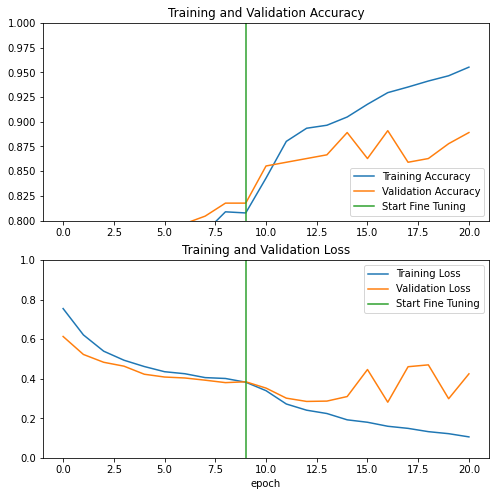

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 108ms/step - loss: 0.2453 - accuracy: 0.9141
Test accuracy : 0.9140625


In [40]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

In [41]:
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)

In [42]:
predictions = tf.where(predictions < 0.5, 0, 1)

In [43]:
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0]
Labels:
 [1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0]


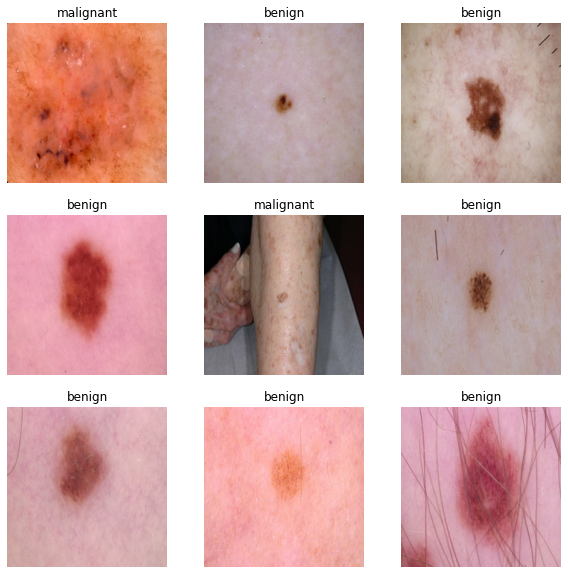

In [44]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [45]:
model.save('/content/drive/MyDrive/dataset/skin_images/resnet50.h5')